In [1919]:
%matplotlib inline
import sys
sys.path.append('/Users/ignasmazelis/Dropbox (HMS)/HMS_Klein-lab')
import helper_functions as hf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.sparse as ssp
#import scrublet as scr
import os

In [1920]:
hf.set_plot_defaults(fontsize=12)

# Define some handy functions

In [1921]:
def plot_total_count_histograms(adata_dict, sample_list, min_bin=10, max_bin=3e4, counts_per_bin=False):
    # Start figure
    fig, nrow, ncol = hf.start_subplot_figure(len(sample_list), row_height=2.5, n_columns=6, fig_width=16, dpi=75)

    for iS,s in enumerate(sample_list):
        # Loop over each library, plotting histogram of total counts (UMIs) per cell

        # Set subplot
        ax = plt.subplot(nrow, ncol, iS+1)

        # Calculate total counts per cells (row sums of counts matrix)
        adata_dict[s].obs['n_counts'] = adata_dict[s].X.sum(1).A.squeeze()

        # Get minimum total counts threshold. Barcodes with 
        # total counts >= min_tot are considered real cells. 
        min_tot = adata_dict[s].uns['min_tot']

        # Plot the histogram
        hf.total_counts_histogram(
            adata_dict[s].obs['n_counts'], 
            min_bin=min_bin, 
            max_bin=max_bin, 
            ax=ax, 
            counts_per_bin=counts_per_bin
        )
        ax.set_title(s, fontsize=12)

        xl = np.array(ax.get_xlim())
        yl = np.array(ax.get_ylim())
        ax.set_xlim(xl)
        ax.set_ylim(yl)

        # Plot the threshold    
        ax.plot(min_tot * np.ones(2), yl, c='black', linewidth=1)

        # Calculate number of barcodes passing filter and show on plot
        mask = adata_dict[s].obs['n_counts'].values >= min_tot
        ntot = adata_dict[s].shape[0]
        npass = mask.sum()
        umitot = adata_dict[s].obs['n_counts'].values.sum()
        umipass = adata_dict[s].obs['n_counts'].values[mask].sum()

        ax.text(
            xl[0] + 10**(np.log10(xl.ptp())*0.05), 
            yl[0] + yl.ptp() * 0.88, 
            '{} / {}'.format(npass, ntot), fontsize=12)
        ax.text(
            xl[0] + 10**(np.log10(xl.ptp())*0.05), 
            yl[0] + yl.ptp() * 0.77, 
            '{:.1f}% UMIs pass'.format(umipass/umitot*100), fontsize=12)

    fig.tight_layout()
    return


def plot_mito_frac_histograms(adata_dict, sample_list, mito_gene_ix):
    # Start figure
    fig, nrow, ncol = hf.start_subplot_figure(len(sample_list), row_height=2.5, n_columns=6, fig_width=16, dpi=75)

    for iS,s in enumerate(sample_list):
        # Loop over each library, plotting histogram of fraction of UMIs
        # coming from mitochondrial genes.

        # Set subplot
        ax = plt.subplot(nrow, ncol, iS+1)
        
        # Calculate fraction of counts from mitochondrial  genes
        adata_dict[s].obs['mito_frac'] = adata_dict[s].X[:,mt_ix].sum(1).A.squeeze() / adata_dict[s].obs['n_counts'].values
        
        max_mt = adata_dict[s].uns['max_mito']
        
        # Plot the histogram
        ax.hist(adata_dict[s].obs['mito_frac'], np.linspace(0, 1, 50));
        ax.set_title(s, fontsize=12)
        ax.set_xlabel('mito. frac.')
        ax.set_ylabel('# barcodes')

        xl = np.array([0,1])
        yl = np.array(ax.get_ylim())
        ax.set_ylim(xl)
        ax.set_ylim(yl)

        # Plot the threshold    
        ax.plot(max_mt * np.ones(2), yl, c='black', linewidth=1)

        # Calculate number of barcodes passing filter and show on plot
        ntot = len(adata_dict[s].obs['mito_frac'])
        npass = (adata_dict[s].obs['mito_frac'] <= max_mt).sum()
        ax.text(
            xl[0] + xl.ptp()*0.98,
            yl[0] + yl.ptp() * 0.88, '{} / {}'.format(npass, ntot), 
            fontsize=12, ha='right')
        ax.text(
            xl[0] + xl.ptp()*0.98, 
            yl[0] + yl.ptp() * 0.77, '{:.1f}% live'.format(npass/ntot*100), 
            fontsize=12, ha='right')

    fig.tight_layout()

    return



## Load HTO data

HTO seq-to-ID dictionary

In [1922]:
hto_name_dict = {                                                                                                             
        'GGACCATC' : 'HTO1',
        'CTGTCTAA' : 'HTO7',
        'CCACCAGT' :'Total_mouse',
        'CAACTCTT' : 'Total_human',
        'GGAGAAGA' : 'Multi1',
        'CCACAATG' : 'Multi2'
}

In [1923]:
hto_names = {                                                                                                             
        'HTO1' : 'GGACCATC',
        'HTO7' : 'CTGTCTAA',
        'Total_mouse' :'CCACCAGT',
        'Total_human' : 'CAACTCTT',
        'Multi1' : 'GGAGAAGA',
        'Multi2' : 'CCACAATG'
}

Samples to load

In [1924]:
# directory to the HTO reads and count.csv files outputed by the python code
sys.path.append('/Users/ignasmazelis/Dropbox (HMS)/HMS_Klein-lab/Hashing/Sequencing/2020-03_NextSeq_TMC/')
# define some libraries
HTO_umis = {} 
HTO_reads = {} 
#Sample names == folder names in the directory
HTO_list = ['Total-seq', 'Multi-seq', 'V2_noflit', 'V2_200x', 'V2_1000x', 'V2_10kx']

# load the data 
for i in HTO_list:
    HTO_umis[i] = pd.read_csv(f'hashtags1/{i}.counts.csv',header=0) 
    HTO_reads[i] = pd.read_csv(f'hashtags1/{i}.reads.csv',header=0)
    #HTO_umis[i].drop('Barcode', axis = 1, inplace = True)
    #HTO_reads[i].drop('Barcode', axis = 1, inplace = True)
    





# QC checks
Do most reads have a valid HTO sequence? If so, is it in the expected location?

In [1925]:
print('{:15s}{:<30s}{:<15s}'.format(
    'sample', '% reads with match', 'total reads (M)'
))

for iS,s in enumerate(HTO_list):
    dat = hf.load_pickle(f'hashtags1/{s}.pickle')
    x = []
    y = []
    start_points = []

    for k,v in dat.items():
        for barcode,umis in v.items():
            if barcode != 'no match':
                start_points.extend([u[0] for u in umis])
        x.append(sum([len(umis) for barcode,umis in v.items() if barcode != 'no match']))
        y.append(v['no match'])

    start_points = np.array(start_points)
    x = np.array(x)
    y = np.array(y)
    n_match_reads = x.sum()
    n_no_match_reads = y.sum() 
    n_reads = n_match_reads + n_no_match_reads
    
    print(
        f'{s:15s}{(n_match_reads / n_reads)*100 :<30.2f}{n_reads/1e6 :<15.2f}'
    )




sample         % reads with match            total reads (M)
Total-seq      97.64                         0.21           
Multi-seq      98.16                         7.37           
V2_noflit      17.31                         0.01           
V2_200x        99.27                         4.19           
V2_1000x       97.66                         6.19           
V2_10kx        69.80                         8.87           


### Load UMI and read tables
(cell barcodes x HTO)

In [1926]:
umi = {}
read = {}

for s in HTO_list:
    # load tables
    umi[s] = pd.read_csv(f'hashtags1/{s}.counts.csv', index_col=0)
    read[s] = pd.read_csv(f'hashtags1/{s}.reads.csv', index_col=0)
    
    # rename columns from HTO seq to HTO name
    umi[s].rename(columns=hto_name_dict, inplace=True)
    read[s].rename(columns=hto_name_dict, inplace=True)
    
    # reorder columns HTO1-HTO8
    umi[s] = umi[s][sorted(list(hto_name_dict.values()))]
    read[s] = read[s][sorted(list(hto_name_dict.values()))]
    

Print total UMIs detected for each HTO

In [1927]:
print('sample    ', ''.join([f'{s:10s}' for s in hto_name_dict.values()]))
for s in HTO_list:
    print(f'{s:10s}', ''.join([f'{x :<10.0f}' for x in umi[s].values.sum(0)]))

sample     HTO1      HTO7      Total_mouseTotal_humanMulti1    Multi2    
Total-seq  8         0         13        0         167046    33759     
Multi-seq  477       738       2167260   1353742   515       8895      
V2_noflit  187       184       368       176       1059      353       
V2_200x    529097    160395    10376     2272      2103      4414      
V2_1000x   259623    429262    22314     5188      6778      6039      
V2_10kx    168927    155191    153888    78460     99451     58960     


Plot number of UMIs for one HTO versus those of another. We expect that there should be very little overlap, i.e. that a given cell barcode only "expresses" a single HTO.

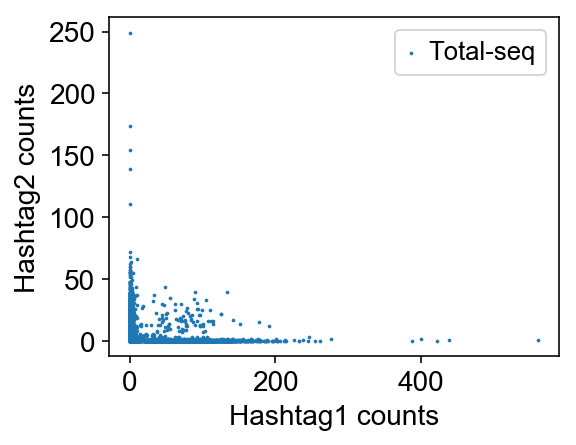

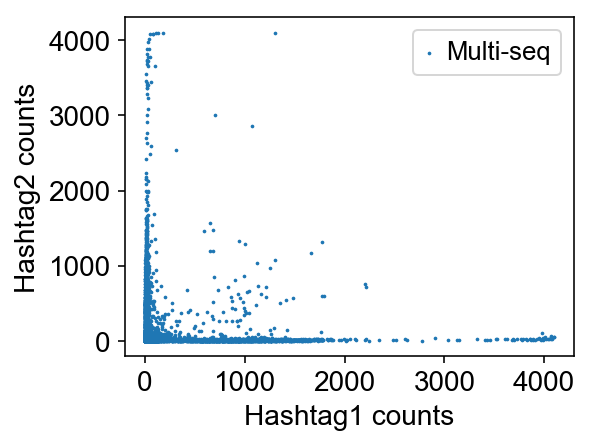

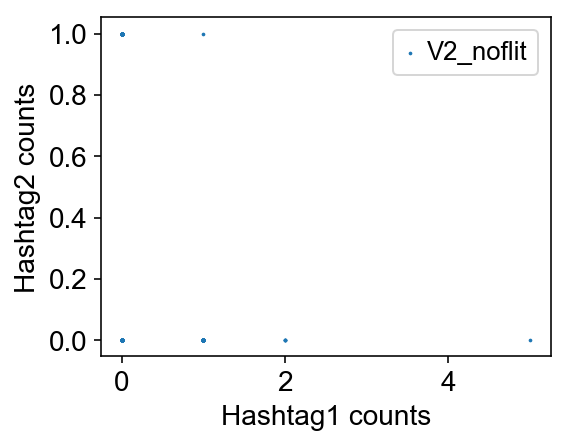

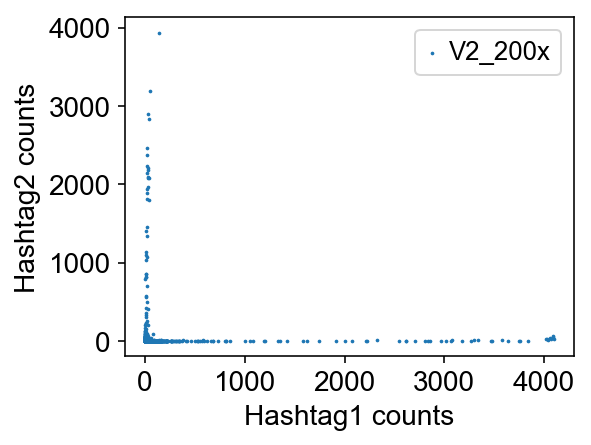

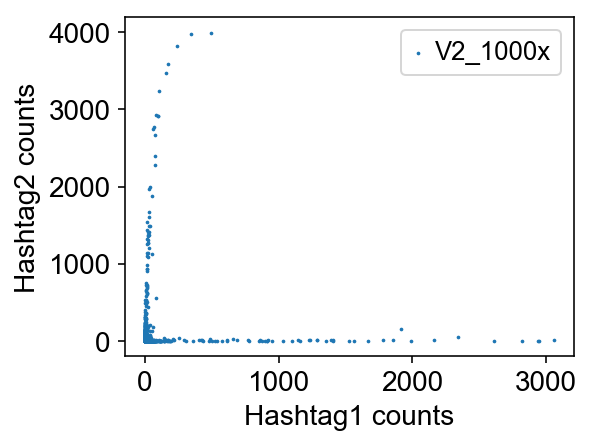

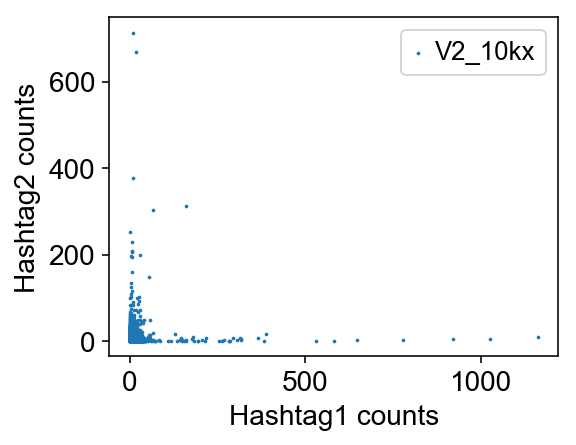

In [1928]:

for iG, i in enumerate(HTO_list):    
    fig, ax = plt.subplots(1, 1, figsize = (4, 3))
    if i.startswith('Total'):
        x = (umi[i]['Total_human'])
        y = (umi[i]['Total_mouse'])
        ax.scatter(x, y, label = f'{i}', s = 0.7)
        
    elif i.startswith('Multi'):
        x = (umi[i]['Multi1'])
        y = (umi[i]['Multi2'])
        ax.scatter(x, y, label = f'{i}', s = 0.7)

    elif i.startswith('V2'):
        x = (umi[i]['HTO1'])
        y = (umi[i]['HTO7'])
        ax.scatter(x, y, label = f'{i}', s = 0.7)

        
    ax.set_xlabel('Hashtag1 counts')
    ax.set_ylabel('Hashtag2 counts')
    #ax.set_xlim(-20, 1000)
    #ax.set_ylim(-20, 1000)
    ax.legend()
    ax.grid(False)
    

# Load transcriptome data

First, let's set the input folder

In [1]:
input_paths = {
    '/Users/ignasmazelis/Dropbox (HMS)/HMS_Klein-lab/Hashing/Sequencing/2020-03_NextSeq_TMC/cell_data' : [
                                                                                                'Total-seq',
                                                                                                 'Multi-seq',
                                                                                                 'V2_noflit',
                                                                                                 'V2_200x',
                                                                                                 'V2_1000x',
                                                                                                 'V2_10kx',
                                                                                                   ]}

h5ad_dir = 'h5ad_files'
plot_dir = '_plots'

# `meta_keys` lists the names of the columns to be added to the .obs dataframe.
# For each key in `meta_keys`, there must be a corresponding entry in the 
# `meta_values` list for each sample.
# Use key 'new name' if you want to convert the original sample IDs into more
# meaningful sample names.
meta_keys = []


# Set ng parameters. These can be
# customized for each library at a later step.

# min number of UMIs per cell barcode, for separating 
# background from real cells
default_min_tot = 500  

# max fraction of UMIs from mitochondrial genes, for 
# separating live and dead cells
default_max_mito_frac = 0.15 






In [2837]:
######

sample_list = []
D = {}
os.makedirs(h5ad_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

for iFold, folder in enumerate(input_paths):
    for orig_name in input_paths[folder]:
        meta_dict = {k: meta_values[orig_name][i] for i,k in enumerate(meta_keys)}
        
        if 'new name' in meta_keys:
            new_name = meta_dict['new name']
        else:
            new_name = orig_name    
        sample_list.append(new_name)
        
        h5ad_filename = f'{h5ad_dir}/{new_name}-raw.h5ad'
        if os.path.exists(h5ad_filename):
            D[new_name] = sc.read(h5ad_filename)
        else:
            X, barcodes, genes = hf.load_annotated_text(
                hf.file_opener(f'{folder}/{orig_name}.counts.tsv.gz'),
                delim='\t',
                read_row_labels=True,
                read_column_labels=True
            )
            D[new_name] = sc.AnnData(X)
            D[new_name].obs_names = barcodes
            D[new_name].var_names = genes
            D[new_name].var_names_make_unique()
            del X, barcodes, genes
                        
            D[new_name].uns['min_tot'] = default_min_tot
            D[new_name].uns['max_mito'] = default_max_mito_frac
            
            
            for k,v in meta_dict.items():
                if k != 'new name':
                    D[new_name].obs[k] = v
                    
            D[new_name].write_h5ad(h5ad_filename, compression='gzip', force_dense=False)

        print('Loaded {}: {} barcodes, {} genes'.format(new_name, *D[new_name].shape))

Loaded Total-seq: 54859 barcodes, 82791 genes
Loaded Multi-seq: 27982 barcodes, 82791 genes
Loaded V2_noflit: 24923 barcodes, 82791 genes
Loaded V2_200x: 3762 barcodes, 82791 genes
Loaded V2_1000x: 4137 barcodes, 82791 genes
Loaded V2_10kx: 26218 barcodes, 82791 genes


Filter AnnData to only include cell barcodes that also appear in the HTO table, then add HTO counts to the AnnData

In [2838]:
for s in sample_list:
    D[f'{s}'].obs['barcode'] = D[f'{s}'].obs_names

Convert the cell barcode names using the pickle file

In [2839]:
for s in sample_list:
    abundant_barcodes = pickle.load( open( '/Users/ignasmazelis/Dropbox (HMS)/HMS_Klein-lab/Hashing/Sequencing/2020-03_NextSeq_TMC/cell_data/' + s + '/abundant_barcodes.pickle', "rb" ) )
    
    bc_converter = {}
    for bc,name in abundant_barcodes.items():
        bc_converter[name[0]] = bc
    
    bc_new = []
    for barcode in D[f'{s}'].obs['barcode'].values:
        bc_new.append(bc_converter[barcode])
    D[f'{s}'].obs['barcode_seq'] = bc_new


In [2840]:
for s in sample_list:
    keep_cell_mask = D[s].obs['barcode_seq'].isin(umi[s].index)
    print(keep_cell_mask.sum(), '/', D[s].shape[0], 'found')
    D[s] = D[s][keep_cell_mask].copy()
    for k in umi[s].columns:
        D[s].obs[k] = umi[s].loc[D[s].obs['barcode_seq'], k].values.copy()
        D[s].obs[f'{k}_reads'] = read[s].loc[D[s].obs['barcode_seq'], k].values.copy()


    D[s].obs['n_counts_txome'] = D[s].X.sum(1).A.squeeze()


20351 / 54859 found
27981 / 27982 found
2039 / 24923 found
3744 / 3762 found
4118 / 4137 found
26125 / 26218 found


## Plot the hashtags before doing any data filtering

In [2834]:
def plot_scat_hist(library, HTO1, HTO2):
    #data
    
    x = np.log10(1+(library.obs['n_counts_txome']))
    y = np.log10(1+(library.obs[HTO1].values + library.obs[HTO2].values))
    
    # definitions for the axes
    left, width = 0.1/2, 0.65/2
    bottom, height = 0.1/2, 0.65/2
    spacing = 0.02
    
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]
    
    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)
    
    # the scatter plot:
    ax_scatter.scatter(x, y, s=1, c= 'black', alpha = 0.7)
    
    # now determine nice limits by hand:
    binwidth = 0.2
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    ax_scatter.set_xlim((-0.2, 5))
    ax_scatter.set_ylim((-0.2, 5))
    
    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=30, color = 'gray')
    ax_histy.hist(y, bins=30, color = 'gray', orientation='horizontal')
    
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    ax_histx.grid(False)
    ax_histy.grid(False)
    ax_scatter.grid(False)
    
    ax_histx.set_ylabel('Count')
    ax_histy.set_xlabel('Count')
    
    #ax_histx.set_yscale('Log')
    #ax_histy.set_xscale('Log')
    
    ax_scatter.set_xlabel('log10(1+TXome counts)')
    ax_scatter.set_ylabel('log10(1+HTO counts)')
    
    plt.show()
    

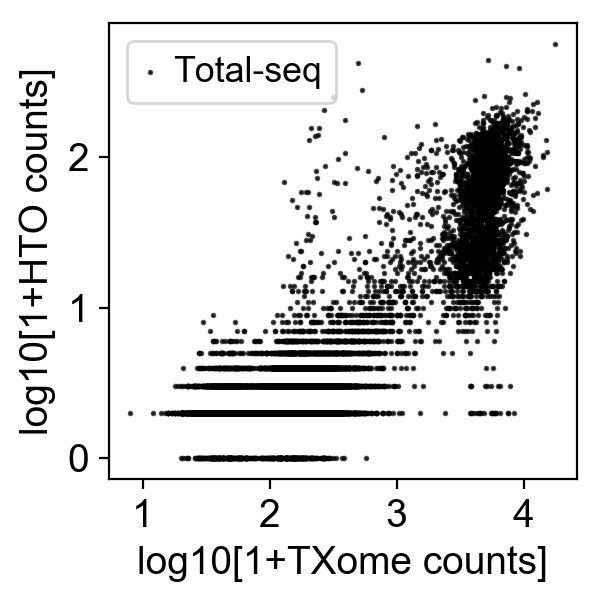

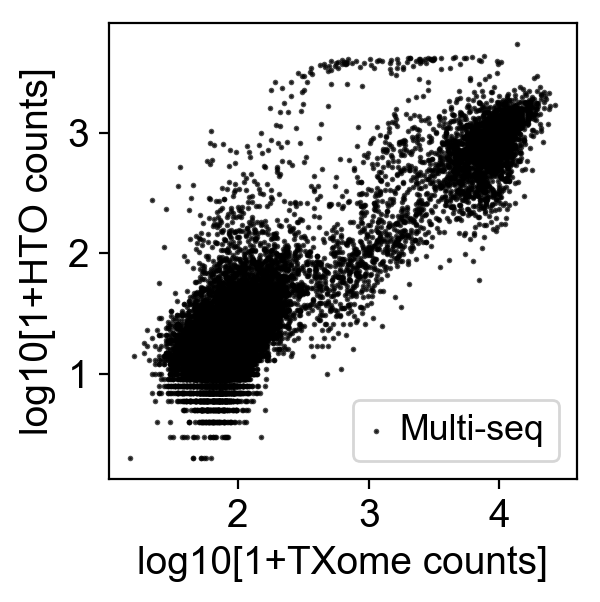

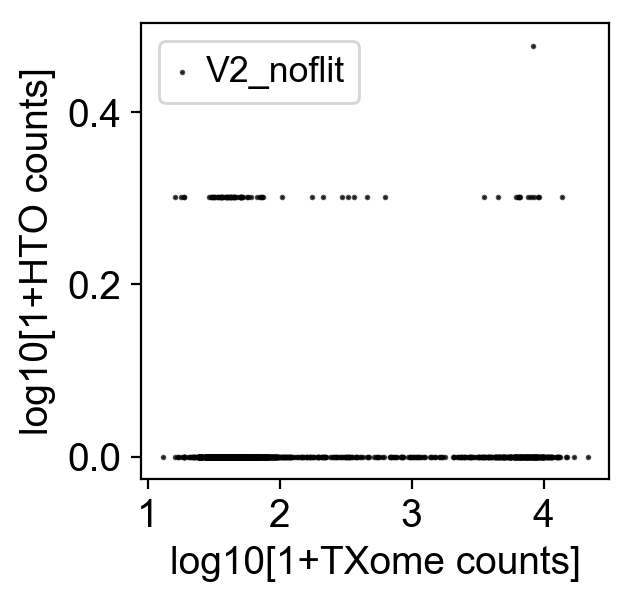

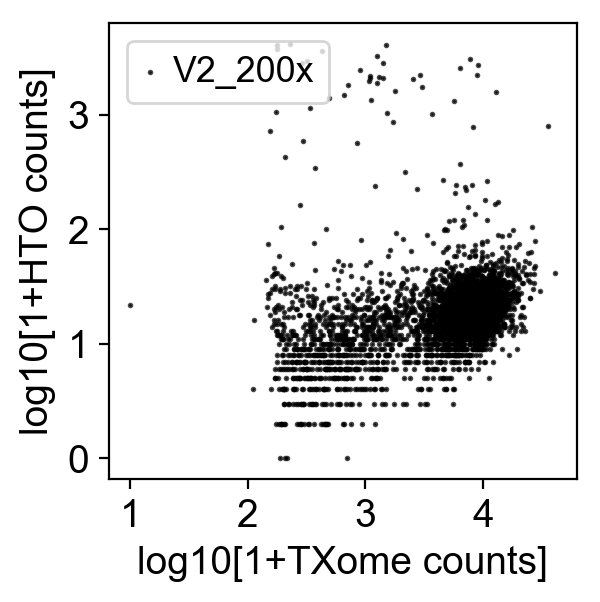

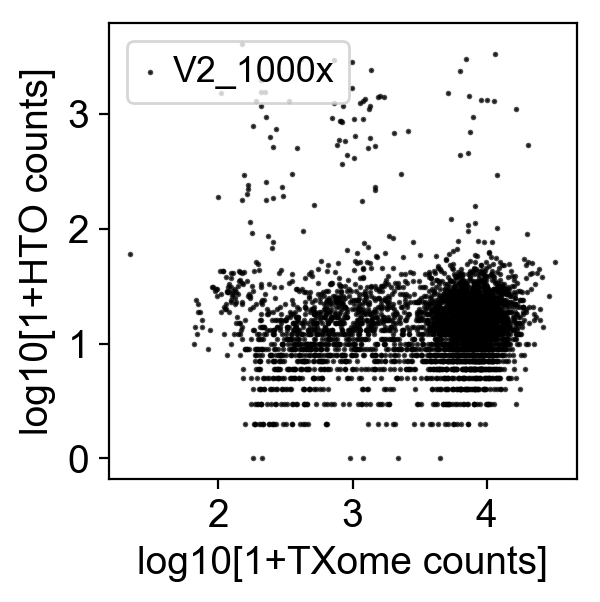

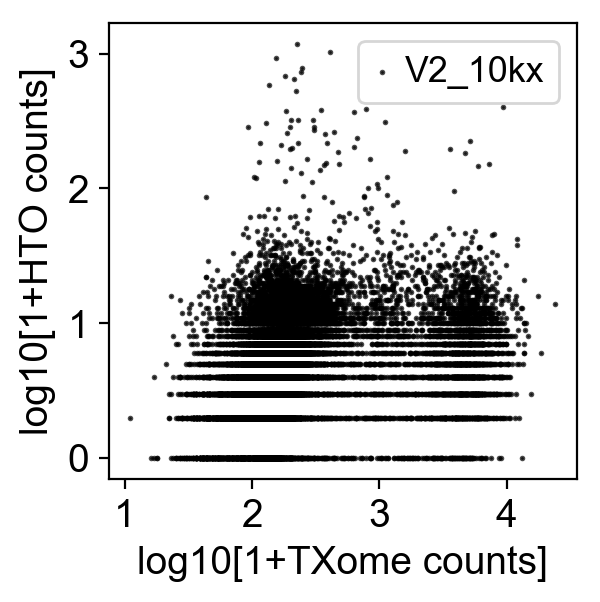

In [2362]:
for i in sample_list:
    fig, ax = plt.subplots(1, 1, figsize = (3, 3), dpi = 100)
    if i.startswith('Total'):
        ax.scatter(np.log10(1+(D[i].obs['n_counts_txome'])),
               np.log10(1+(D[i].obs['Total_human'].values + D[i].obs['Total_mouse'].values)),
               s = 1, c ='black', alpha = 0.7, label = i)
   
    elif i.startswith('Multi'):
        ax.scatter(np.log10(1+(D[i].obs['n_counts_txome'])),
               np.log10(1+(D[i].obs['Multi1'].values + D[i].obs['Multi2'].values)),
               s = 1, c ='black', alpha = 0.7, label = i)    

    elif i.startswith('V2'):
        ax.scatter(np.log10(1+(D[i].obs['n_counts_txome'])),
               np.log10(1+(D[i].obs['HTO1'].values + D[i].obs['HTO7'].values)),
               s = 1, c ='black', alpha = 0.7, label = i)

    ax.set_xlabel('log10[1+TXome counts]')
    ax.set_ylabel('log10[1+HTO counts]')
    #ax.set_xlim(-500, 15000)
    #ax.set_ylim(0, 1000)
    ax.grid(False)
    ax.legend()

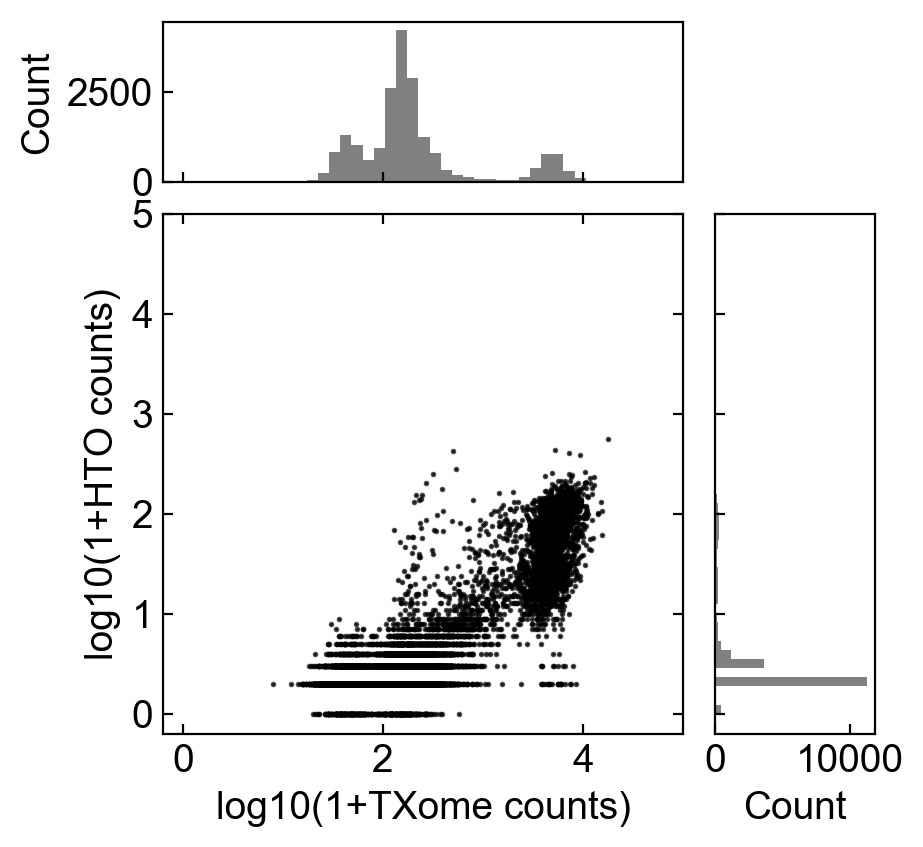

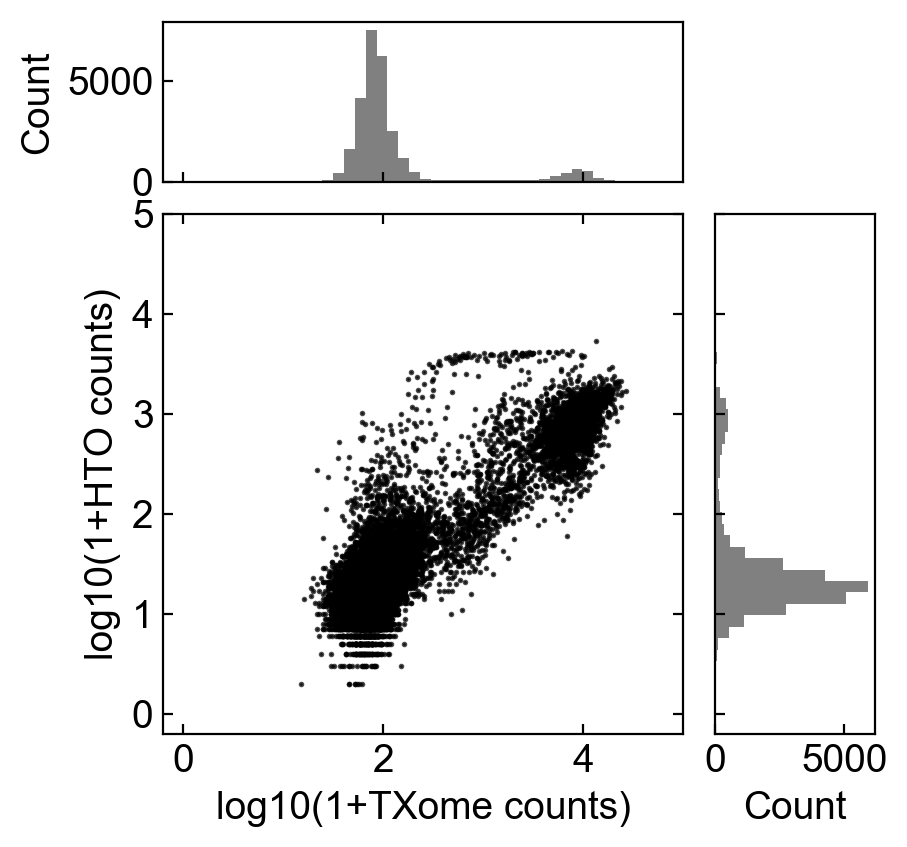

In [2841]:
for i in sample_list:
    if i.startswith('Total'):
        plot_scat_hist(D[i], 'Total_human', 'Total_mouse')
    elif i.startswith('Multi'):
        plot_scat_hist(D[i], 'Multi1', 'Multi2')
    #elif i.startswith('V2'):
    #    plot_scat_hist(D[i], 'HTO1', 'HTO7')

    #ax.set_xlabel('log10(1+TXome counts)')
    #ax.set_ylabel('log10(1+HTO counts)')
    #ax.set_xlim(0, 5)
    #ax.set_ylim(0, 5)
    #ax.grid(False)
    #ax.legend()

## Data filtering

Set thresholds for filtering out background

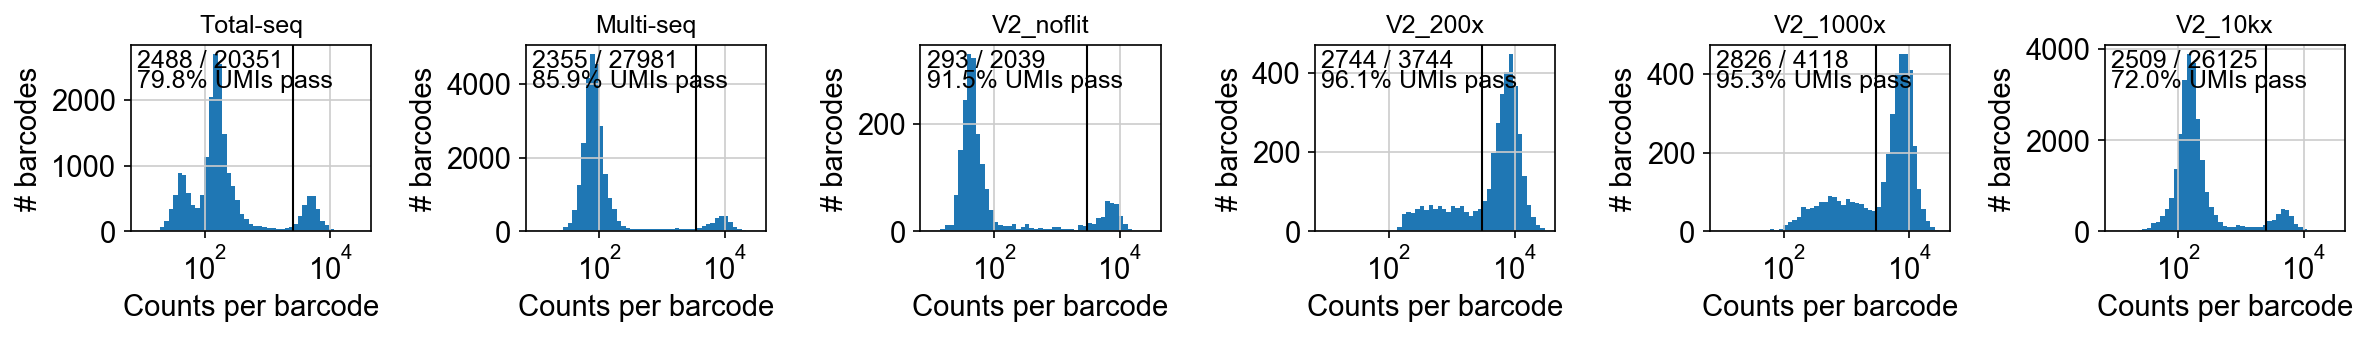

In [2842]:
# Change total count thresholds based on the histograms. 
#D['Total-seq_hum'].uns['min_tot'] = 1000
D['Total-seq'].uns['min_tot'] = 2500

D['Multi-seq'].uns['min_tot'] = 3500

D['V2_noflit'].uns['min_tot'] = 3000

D['V2_200x'].uns['min_tot'] = 3000

D['V2_1000x'].uns['min_tot'] = 3000

D['V2_10kx'].uns['min_tot'] = 2500











# Plot histograms with thresholds
plot_total_count_histograms(D, sample_list, counts_per_bin=False)


Now actually apply the filtering

In [2843]:
print('{:20s}{:>25s}{:>25s}'.format('Sample', '# barcodes pre-filter', '# barcodes post-filter'))

for s in sample_list:
    keep = D[s].obs['n_counts'] >= D[s].uns['min_tot']
    D[s] = D[s][keep].copy()
    n_orig = len(keep)
    n_pass = keep.sum()
    print('{:20s}{:>25}{:>25}'.format(s, n_orig, n_pass))
    

Sample                  # barcodes pre-filter   # barcodes post-filter
Total-seq                               20351                     2488
Multi-seq                               27981                     2355
V2_noflit                                2039                      293
V2_200x                                  3744                     2744
V2_1000x                                 4118                     2826
V2_10kx                                 26125                     2509


Find mitochondrial genes

In [2844]:
gene_list = D[s].var_names.values.astype(str)
mt_ix = np.array([i for i,g in enumerate(gene_list) if g.startswith('MT-') or g.startswith('mt-')], dtype=int)
print(gene_list[mt_ix])

['MT-ATP6_hg' 'MT-ATP8_hg' 'MT-CO1_hg' 'MT-CO2_hg' 'MT-CO3_hg' 'MT-CYB_hg'
 'MT-ND1_hg' 'MT-ND2_hg' 'MT-ND3_hg' 'MT-ND4_hg' 'MT-ND4L_hg' 'MT-ND5_hg'
 'MT-ND6_hg' 'MT-RNR1_hg' 'MT-RNR2_hg' 'MT-TA_hg' 'MT-TC_hg' 'MT-TD_hg'
 'MT-TE_hg' 'MT-TF_hg' 'MT-TG_hg' 'MT-TH_hg' 'MT-TI_hg' 'MT-TK_hg'
 'MT-TL1_hg' 'MT-TL2_hg' 'MT-TM_hg' 'MT-TN_hg' 'MT-TP_hg' 'MT-TQ_hg'
 'MT-TR_hg' 'MT-TS1_hg' 'MT-TS2_hg' 'MT-TT_hg' 'MT-TV_hg' 'MT-TW_hg'
 'MT-TY_hg' 'mt-Atp6_mm' 'mt-Atp8_mm' 'mt-Co1_mm' 'mt-Co2_mm' 'mt-Co3_mm'
 'mt-Cytb_mm' 'mt-Nd1_mm' 'mt-Nd2_mm' 'mt-Nd3_mm' 'mt-Nd4_mm' 'mt-Nd4l_mm'
 'mt-Nd5_mm' 'mt-Nd6_mm' 'mt-Rnr1_mm' 'mt-Rnr2_mm' 'mt-Ta_mm' 'mt-Tc_mm'
 'mt-Td_mm' 'mt-Te_mm' 'mt-Tf_mm' 'mt-Tg_mm' 'mt-Th_mm' 'mt-Ti_mm'
 'mt-Tk_mm' 'mt-Tl1_mm' 'mt-Tl2_mm' 'mt-Tm_mm' 'mt-Tn_mm' 'mt-Tp_mm'
 'mt-Tq_mm' 'mt-Tr_mm' 'mt-Ts1_mm' 'mt-Ts2_mm' 'mt-Tt_mm' 'mt-Tv_mm'
 'mt-Tw_mm' 'mt-Ty_mm']


Set thresholds for filtering out dead (mito-high) cells

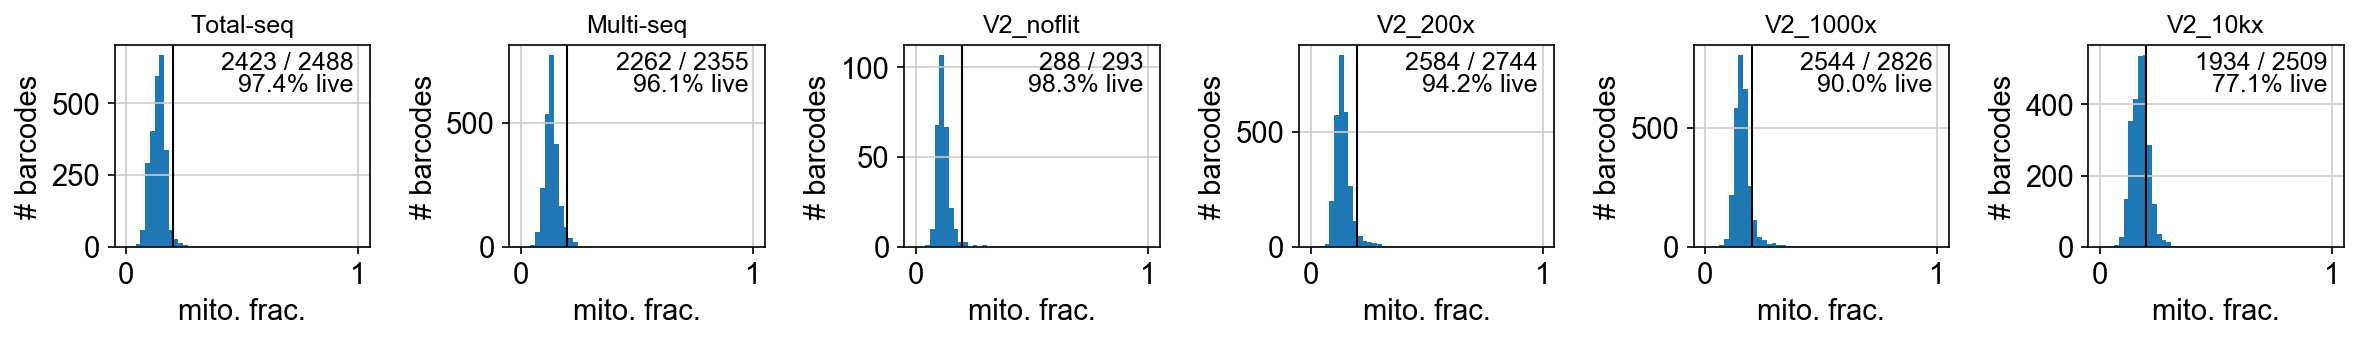

In [2845]:
# Adjust max mito. frac. thresholds based on the histograms
for s in sample_list:
    
    D[f'{s}'].uns['max_mito'] = 0.2
    #D_bg[f'{s}'].uns['max_mito'] = 0.2

# Plot histograms with thresholds
plot_mito_frac_histograms(D, sample_list, mito_gene_ix=mt_ix)


Now actually apply the filtering

In [2846]:
print('{:20s}{:>25s}{:>25s}'.format('Sample', '# barcodes pre-filter', '# barcodes post-filter'))

for s in sample_list:
    keep = D[s].obs['mito_frac'] <= D[s].uns['max_mito']
    D[s] = D[s][keep].copy()
    
    n_orig = len(keep)
    n_pass = keep.sum()
    print('{:20s}{:>25}{:>25}'.format(s, n_orig, n_pass))


Sample                  # barcodes pre-filter   # barcodes post-filter
Total-seq                                2488                     2423
Multi-seq                                2355                     2262
V2_noflit                                 293                      288
V2_200x                                  2744                     2584
V2_1000x                                 2826                     2544
V2_10kx                                  2509                     1934


## Plot graphs post data filtering

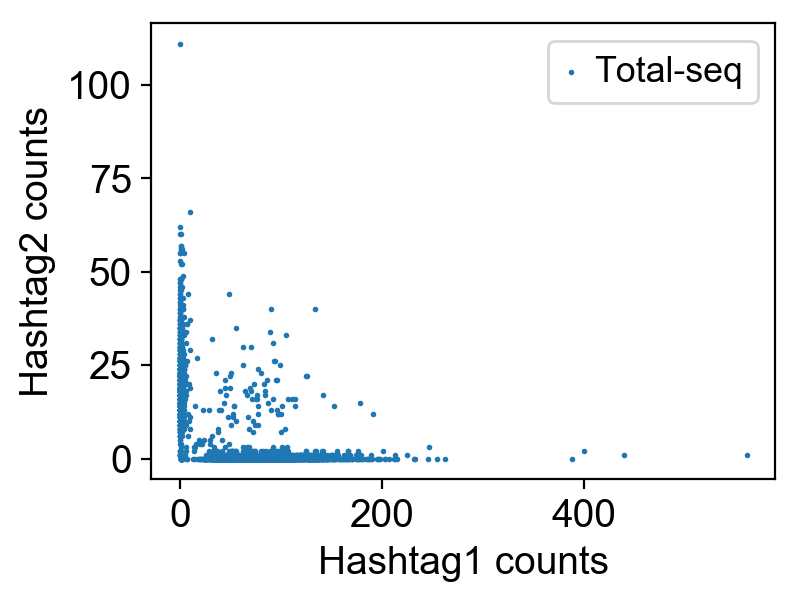

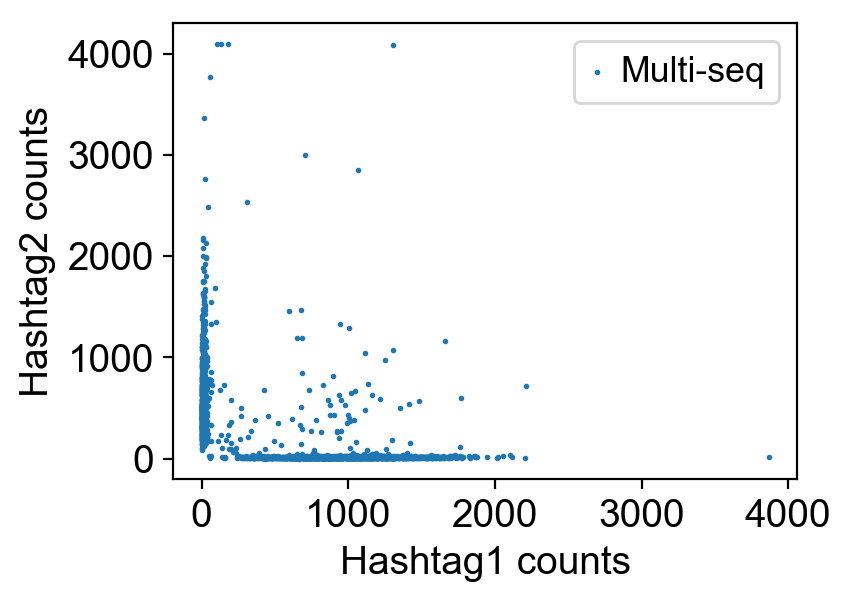

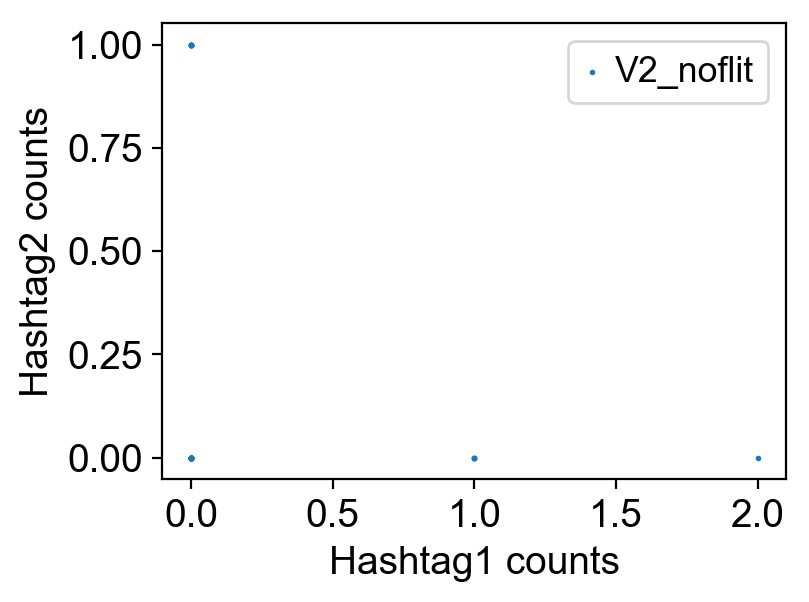

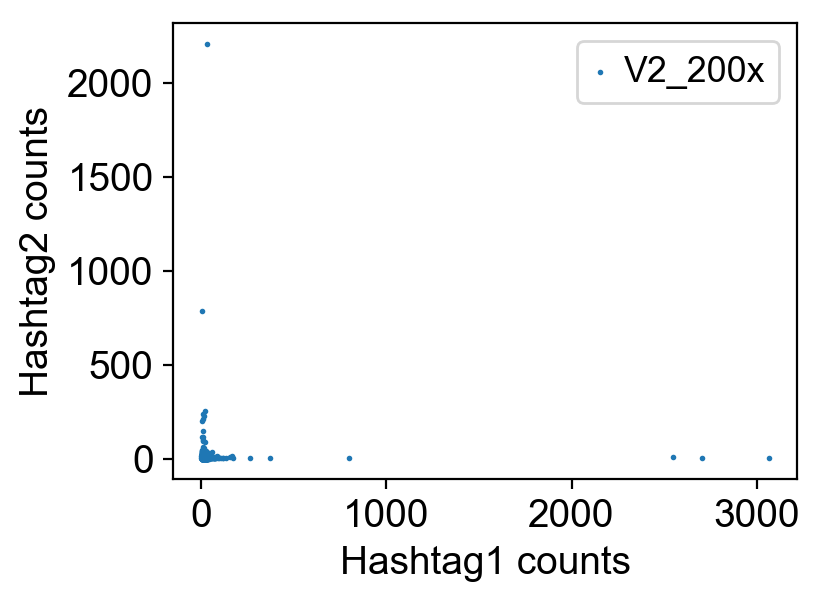

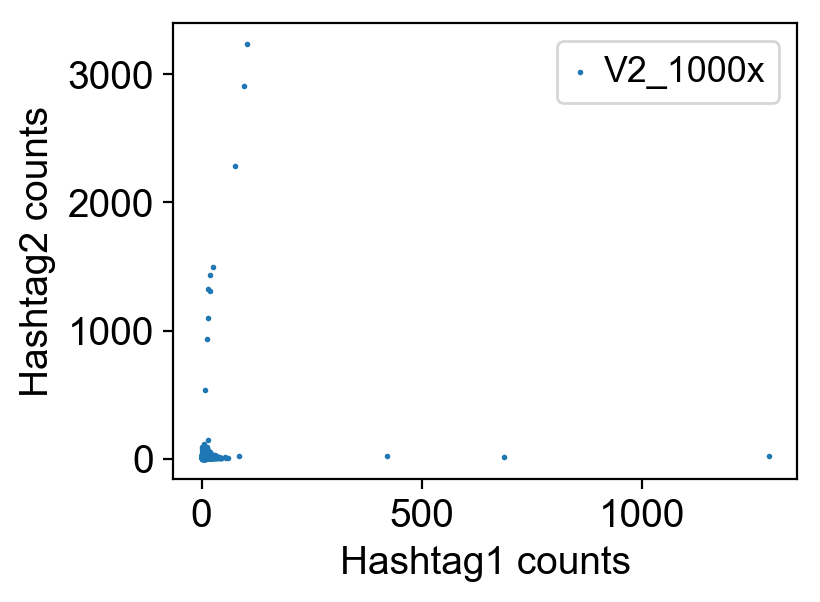

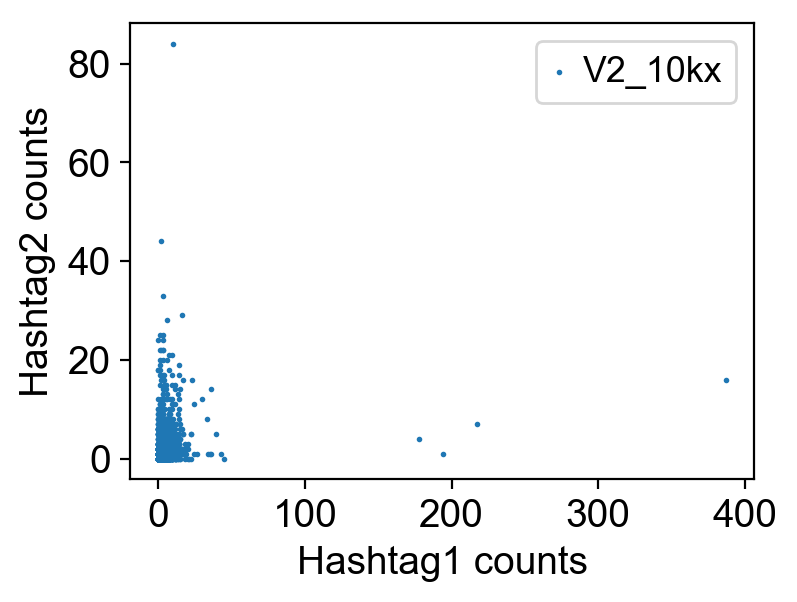

In [2254]:
sc.set_figure_params(dpi = 100)
for s in sample_list:  
    fig, ax = plt.subplots(1, 1, figsize = (4, 3))
    if s.startswith('Total'):
        
        x = (D[s].obs['Total_human'])
        y = (D[s].obs['Total_mouse'])
        ax.scatter(x, y, label = s, s = 1)
        
    elif s.startswith('Multi'):
        x = (D[s].obs['Multi1'])
        y = (D[s].obs['Multi2'])
        ax.scatter(x, y, label = s, s = 1)
        
    elif s.startswith('V2'):
        x = (D[s].obs['HTO1'])
        y = (D[s].obs['HTO7'])
        ax.scatter(x, y, label = s, s = 1)    
        
    ax.set_xlabel('Hashtag1 counts')
    ax.set_ylabel('Hashtag2 counts')
    #ax.set_xlim(-20, 1000)
    #ax.set_ylim(-20, 1000)
    ax.legend()
    ax.grid(False)
    

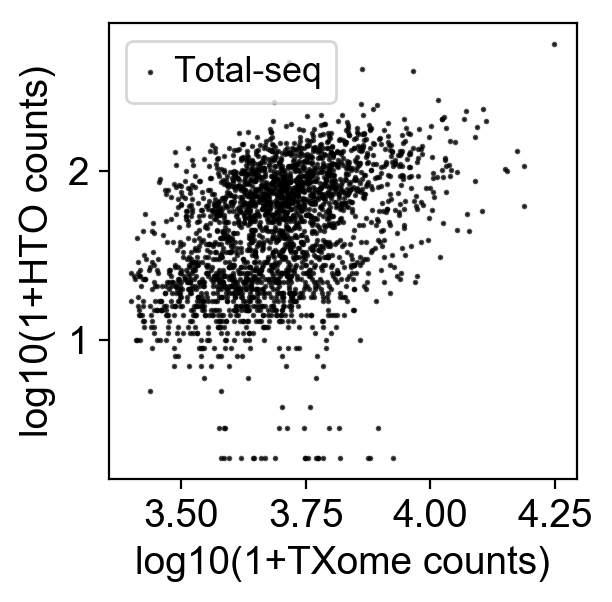

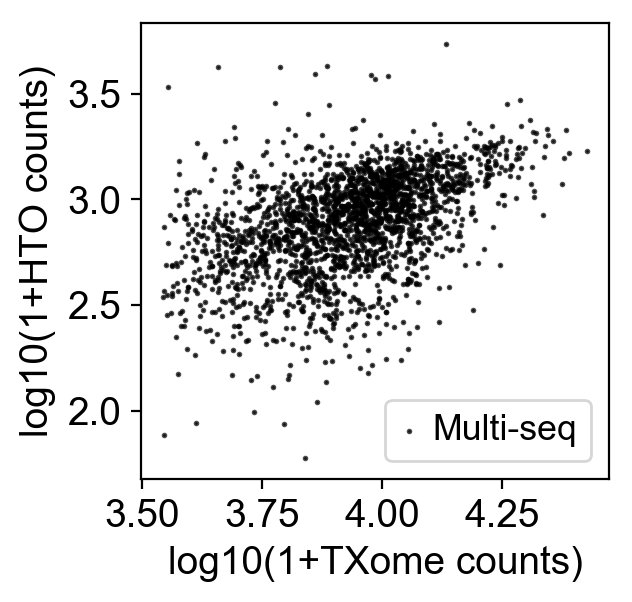

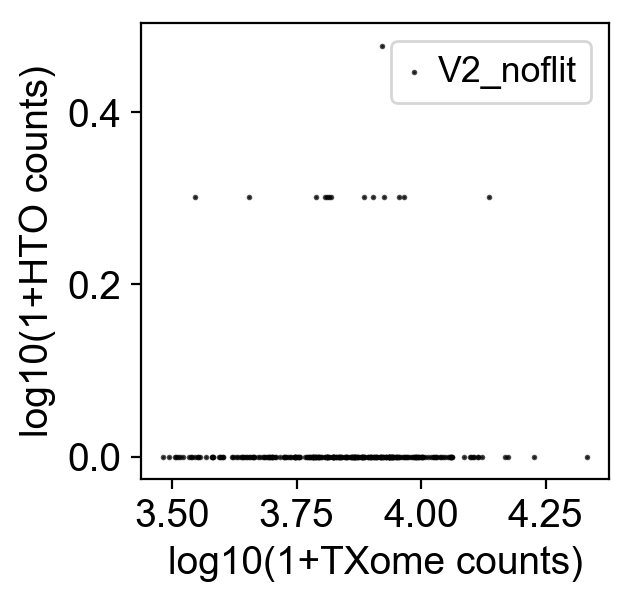

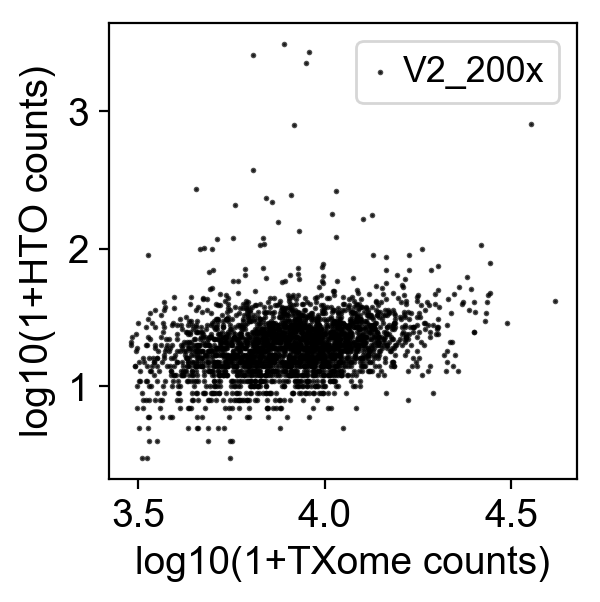

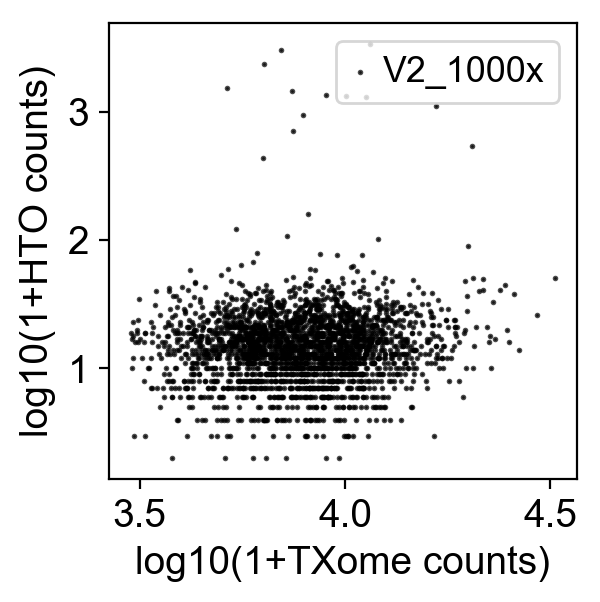

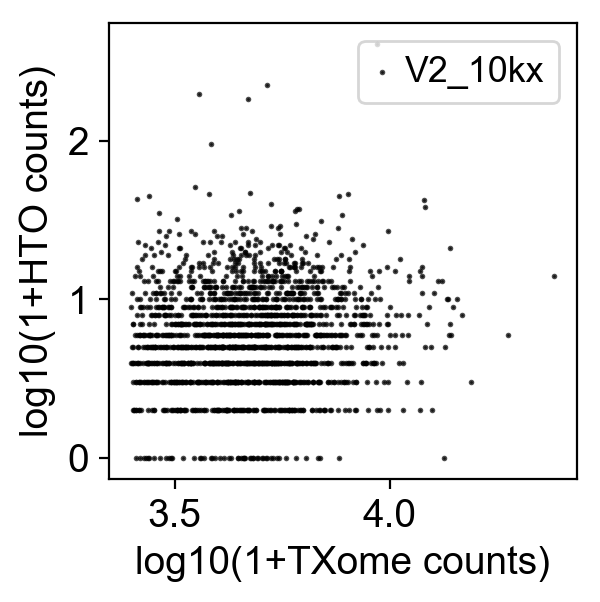

In [2750]:
for i in sample_list:
    fig, ax = plt.subplots(1, 1, figsize = (3, 3), dpi = 100)
    if i.startswith('Total'):
        ax.scatter(np.log10(1+(D[i].obs['n_counts_txome'])),
               np.log10(1+(D[i].obs['Total_human'].values + D[i].obs['Total_mouse'].values)),
               s = 1, c ='black', alpha = 0.7, label = i)
   
    elif i.startswith('Multi'):
        ax.scatter(np.log10(1+(D[i].obs['n_counts_txome'])),
               np.log10(1+(D[i].obs['Multi1'].values + D[i].obs['Multi2'].values)),
               s = 1, c ='black', alpha = 0.7, label = i)    

    elif i.startswith('V2'):
        ax.scatter(np.log10(1+(D[i].obs['n_counts_txome'])),
               np.log10(1+(D[i].obs['HTO1'].values + D[i].obs['HTO7'].values)),
               s = 1, c ='black', alpha = 0.7, label = i)

    ax.set_xlabel('log10(1+TXome counts)')
    ax.set_ylabel('log10(1+HTO counts)')
    #ax.set_xlim(0, 5)
    #ax.set_ylim(0, 5)
    ax.grid(False)
    ax.legend()

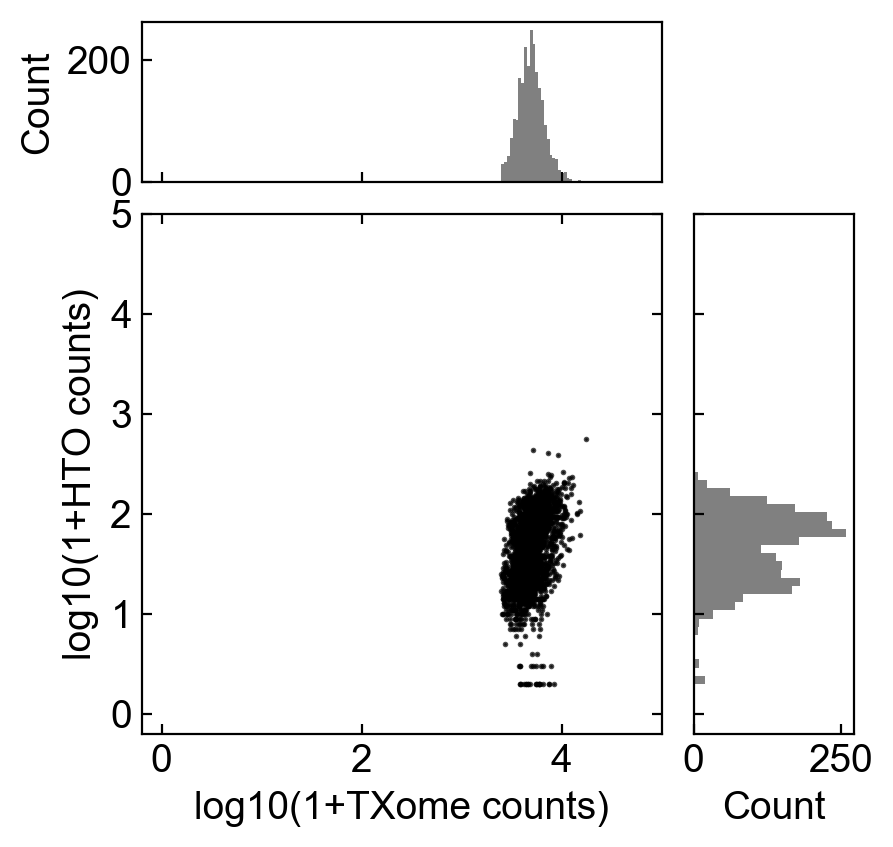

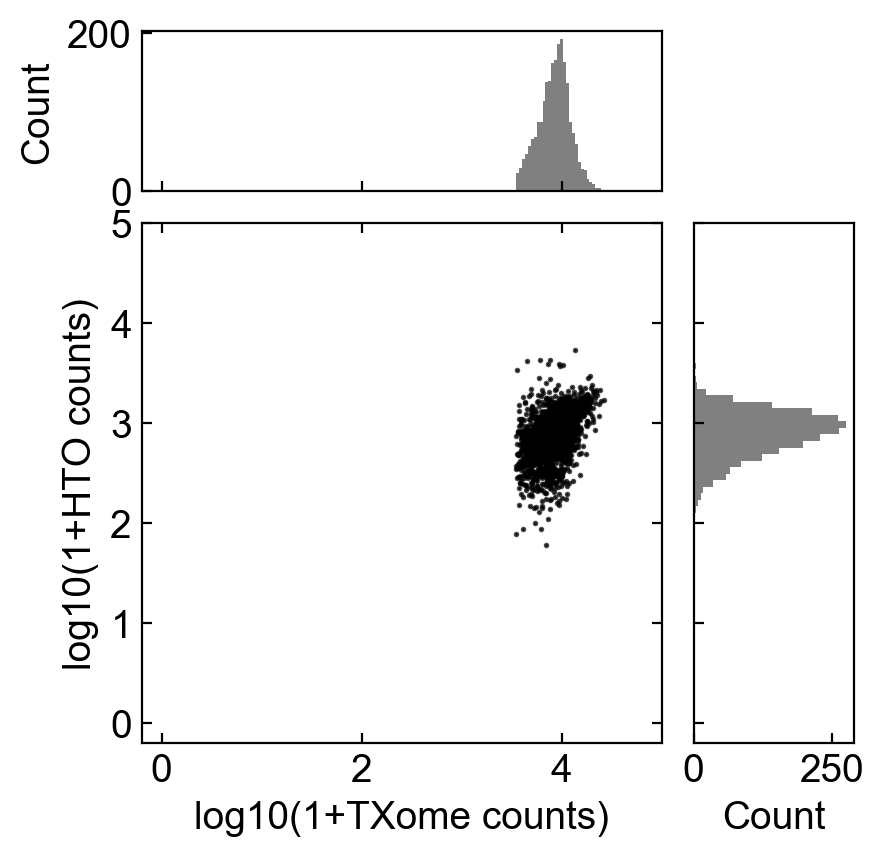

In [2847]:
for i in sample_list:
    if i.startswith('Total'):
        plot_scat_hist(D[i], 'Total_human', 'Total_mouse')
    elif i.startswith('Multi'):
        plot_scat_hist(D[i], 'Multi1', 'Multi2')
    #elif i.startswith('V2'):
    #    plot_scat_hist(D[i], 'HTO1', 'HTO7')

    #ax.set_xlabel('log10(1+TXome counts)')
    #ax.set_ylabel('log10(1+HTO counts)')
    #ax.set_xlim(0, 5)
    #ax.set_ylim(0, 5)
    #ax.grid(False)
    #ax.legend()

In [2093]:
len(D_ribo['Multi-seq'][D_ribo['Multi-seq']<0.25])

63

### Process the data to get a UMAP embedding

____________Total-seq___________
    normalizing...
    filtering genes...


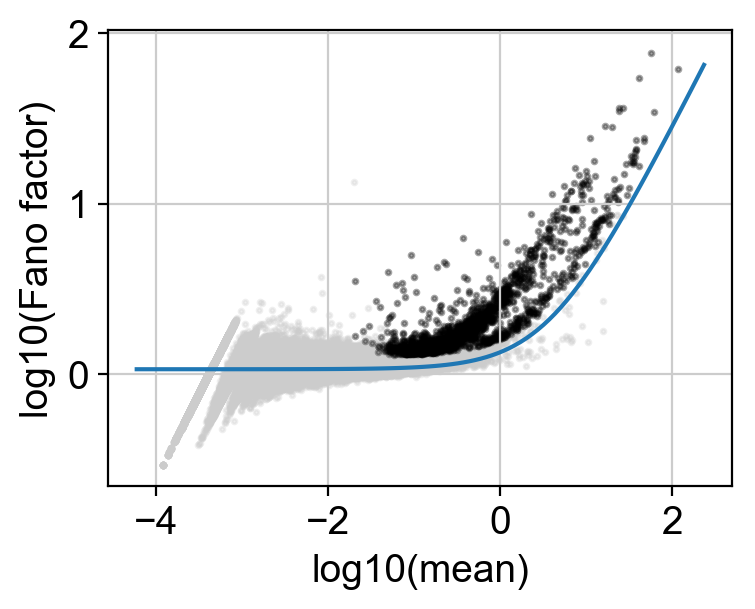

        2296 highly variable genes
    running PCA...
    finding neighbors...
    running UMAP...
    running Leiden clustering...
____________Multi-seq___________
    normalizing...
    filtering genes...


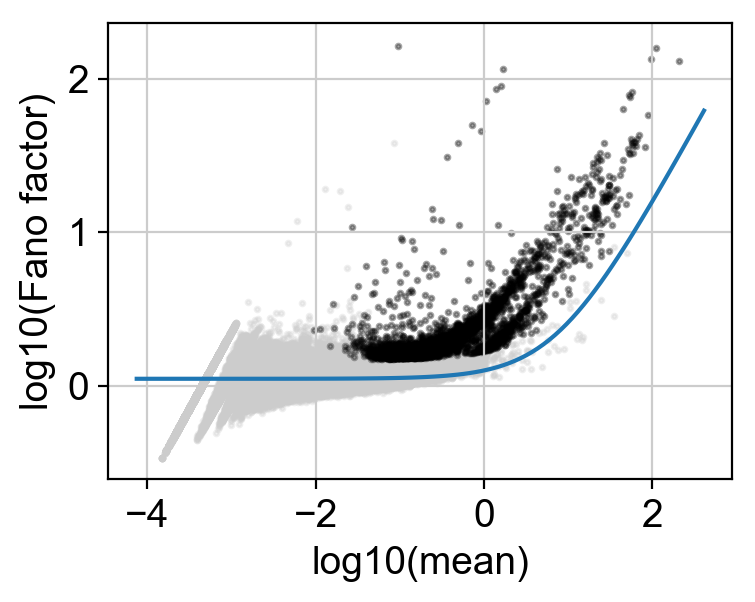

        4245 highly variable genes
    running PCA...
    finding neighbors...
    running UMAP...
    running Leiden clustering...


In [2980]:
sample_list = ['Total-seq', 'Multi-seq'
              ]
D_proc = {}
for s in sample_list:
    print(f'____________{s}___________')
    D_proc[s] = hf.process_ad(
                    D[s],
                    plot_vscore=True,
                    n_components = 30,
                    n_neighbors=15,
                    verbose=True,
                    copy=True
                    )

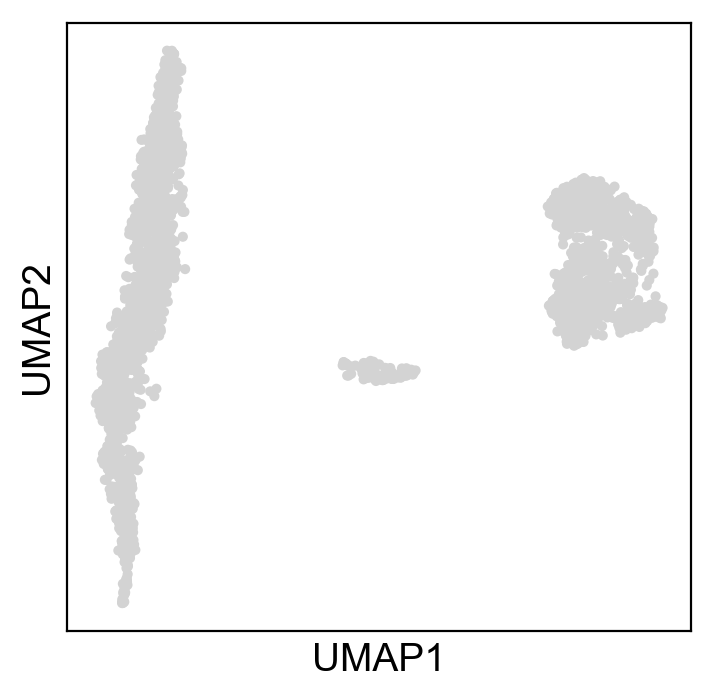

In [2981]:
sc.pl.umap(D_proc['Multi-seq'])

## Multi-seq

1260 / 2262 called HTO1
916 / 2262 called HTO2
86 / 2262 called both
3.801945181255526 % of doublets


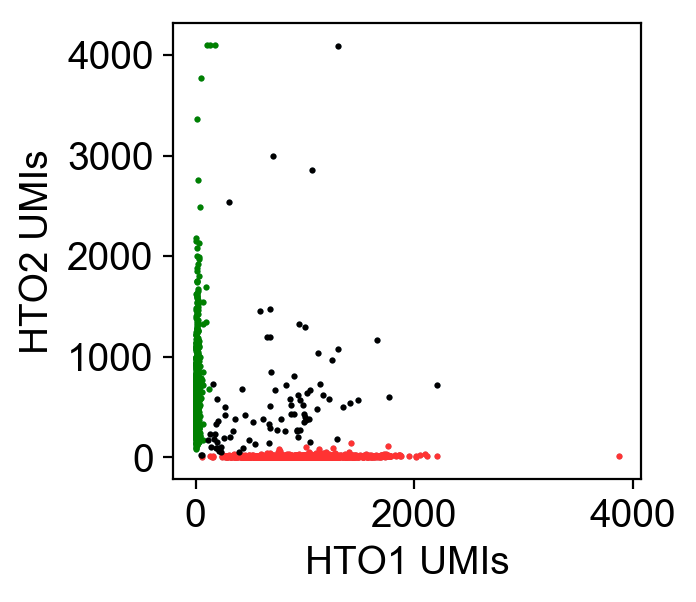

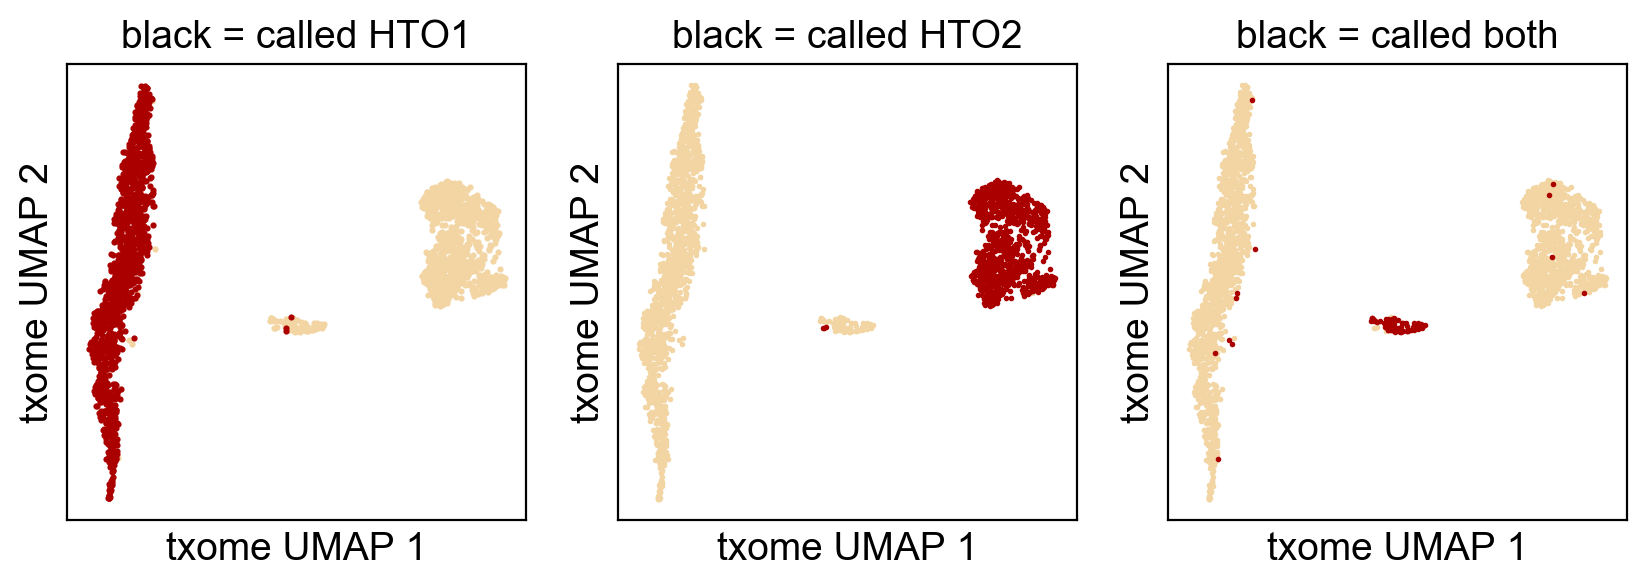

In [3007]:
c_bg = '#f2d5a3'
c_call= '#ab0000'

sam = D_proc['Multi-seq']

x_umap, y_umap = sam.obsm['X_umap'].T

# Plot HTO2 vs. HTO
xdat = sam.obs['Multi1'].values
ydat = sam.obs['Multi2'].values
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(xdat, ydat, alpha=1, s=1)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('HTO1 UMIs')
ax.set_ylabel('HTO2 UMIs')
ax.grid(False)

# Hashtag assigment parameters
m=3
b=0


mask1 = (ydat < (b+9 + (m-2.8945) * xdat))
mask2 = (ydat >= (b+0.05*xdat**2 + (m-4.9) * xdat))

mask3 = ~(mask1 ^ mask2)
ax.scatter(xdat[mask1], ydat[mask1], c='#ff3333', s=1.5)
ax.scatter(xdat[mask2], ydat[mask2], c='green', s=1.5)
ax.scatter(xdat[mask3], ydat[mask3], c='black', s=1.5, alpha = 1)


# Plot the HTO calls on the UMAP embedding
fig,axs=plt.subplots(1,3,figsize=(10,3))
ax = axs[0]
ax.scatter(x_umap[~mask1], y_umap[~mask1], c='#f2d5a3', s=1.5)
ax.scatter(x_umap[mask1], y_umap[mask1], c='#ab0000', s=1.5)
ax.set_title('black = called HTO1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('txome UMAP 1')
ax.set_ylabel('txome UMAP 2')

print(mask1.sum(), '/', len(mask1), 'called HTO1')

ax=axs[1]
ax.scatter(x_umap[~mask2], y_umap[~mask2], c='#f2d5a3', s=1)
ax.scatter(x_umap[mask2], y_umap[mask2], c='#ab0000', s=1)
ax.set_title('black = called HTO2')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('txome UMAP 1')
ax.set_ylabel('txome UMAP 2')
print(mask2.sum(), '/', len(mask2), 'called HTO2')

ax=axs[2]
ax.scatter(x_umap[~mask3], y_umap[~mask3], c='#f2d5a3', s=1)
ax.scatter(x_umap[mask3], y_umap[mask3], c='#ab0000', s=1)
ax.set_title('black = called both')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('txome UMAP 1')
ax.set_ylabel('txome UMAP 2')
print(mask3.sum(), '/', len(mask3), 'called both')
print(mask3.sum()/len(mask3)*100, '% of doublets')

1265 / 2262 called Human
917 / 2262 called Mouse
80 / 2262 called mixed
3.5366931918656057 % of doublets


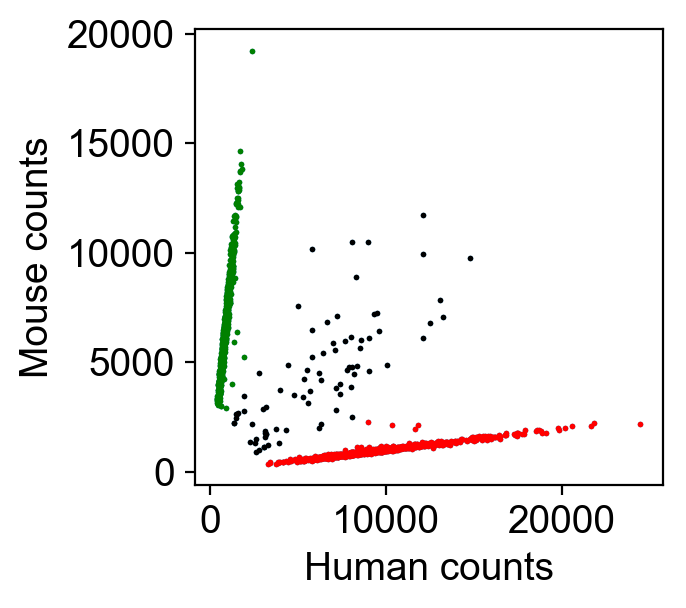

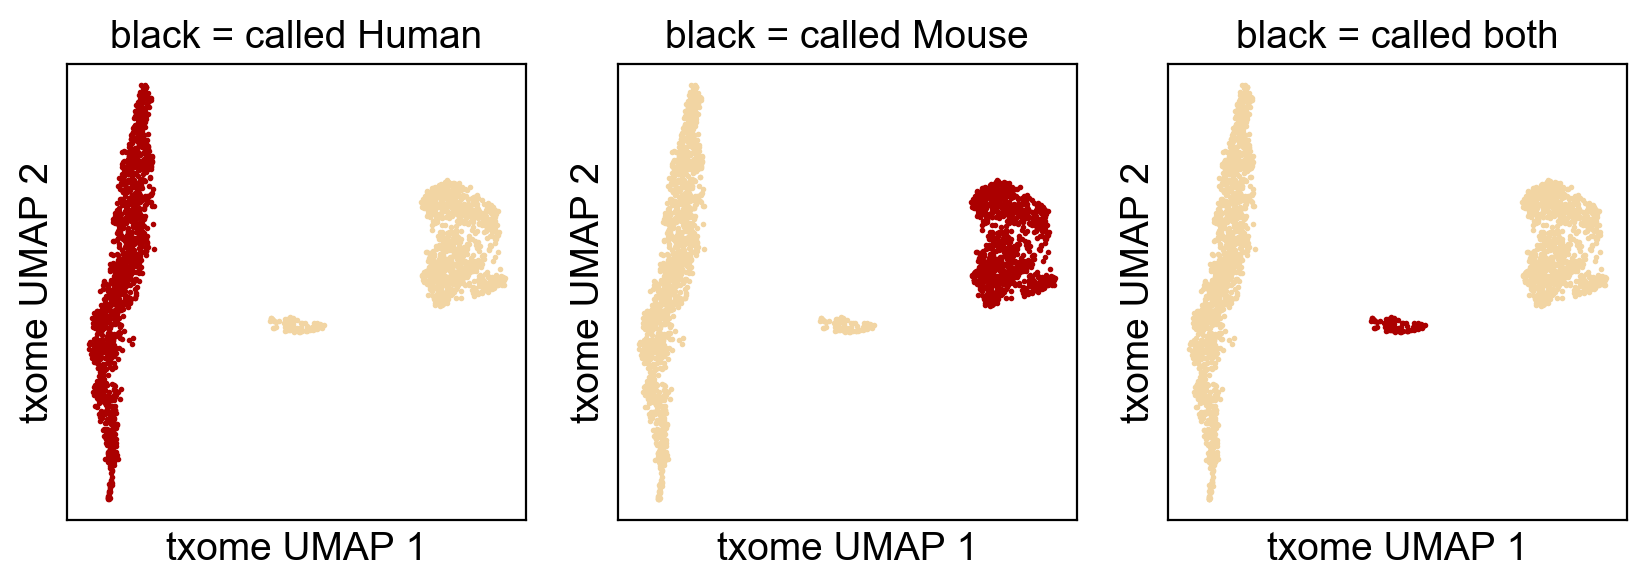

In [3008]:
sam = D_proc['Multi-seq']

x_umap, y_umap = sam.obsm['X_umap'].T

# Plot HTO2 vs. HTO
xdat = sam.obs['hg_count'].values
ydat = sam.obs['mm_count'].values
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(xdat, ydat, alpha=1, s=1)
ax.grid(False)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Human counts')
ax.set_ylabel('Mouse counts')


# Hashtag assigment parameters
m=1
b=0


mask1_sp = (ydat < (b + (m-0.7) * xdat))
mask2_sp = (ydat >= (b + (m+1.5) * xdat))
mask3_sp = ~(mask1_sp ^ mask2_sp)
ax.scatter(xdat[mask1_sp], ydat[mask1_sp], c='red', s=1)
ax.scatter(xdat[mask2_sp], ydat[mask2_sp], c='green', s=1)
ax.scatter(xdat[mask3_sp], ydat[mask3_sp], c='black', s=1)


# Plot the HTO calls on the UMAP embedding
fig,axs=plt.subplots(1,3,figsize=(10,3))
ax = axs[0]
ax.scatter(x_umap[~mask1_sp], y_umap[~mask1_sp], c=c_bg, s=1)
ax.scatter(x_umap[mask1_sp], y_umap[mask1_sp], c=c_call, s=1)
ax.set_title('black = called Human')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('txome UMAP 1')
ax.set_ylabel('txome UMAP 2')
print(mask1_sp.sum(), '/', len(mask1_sp), 'called Human')


ax=axs[1]
ax.scatter(x_umap[~mask2_sp], y_umap[~mask2_sp], c=c_bg, s=1)
ax.scatter(x_umap[mask2_sp], y_umap[mask2_sp], c=c_call, s=1)
ax.set_title('black = called Mouse')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('txome UMAP 1')
ax.set_ylabel('txome UMAP 2')
print(mask2_sp.sum(), '/', len(mask2_sp), 'called Mouse')

ax=axs[2]
ax.scatter(x_umap[~mask3_sp], y_umap[~mask3_sp], c=c_bg, s=1)
ax.scatter(x_umap[mask3_sp], y_umap[mask3_sp], c=c_call, s=1)
ax.set_title('black = called both')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('txome UMAP 1')
ax.set_ylabel('txome UMAP 2')
print(mask3_sp.sum(), '/', len(mask3_sp), 'called mixed')
print(mask3_sp.sum()/len(mask3_sp)*100, '% of doublets')

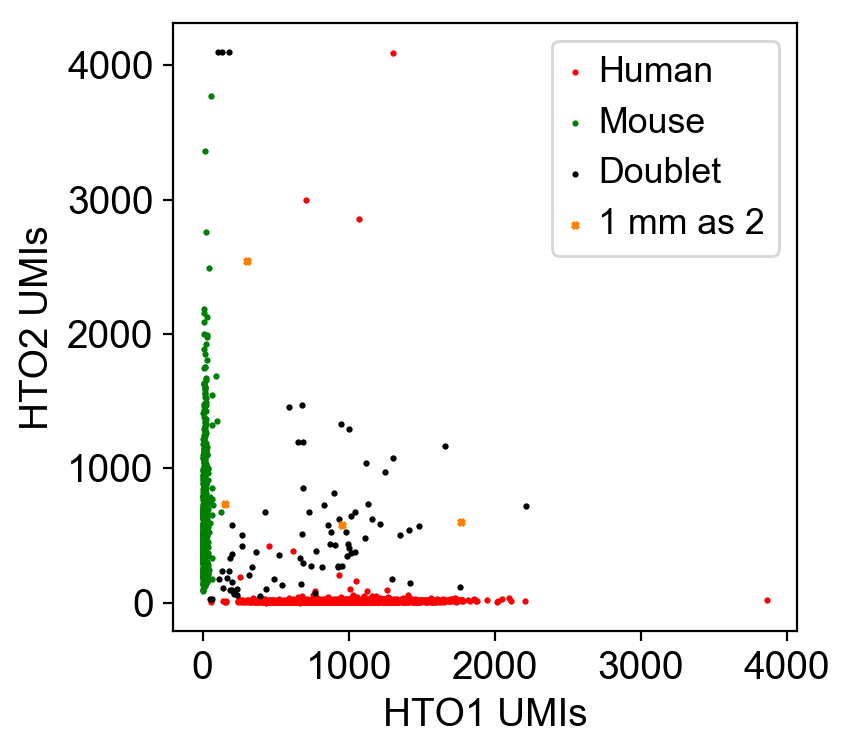

In [2932]:
sam = D_proc['Multi-seq']

x_umap, y_umap = sam.obsm['X_umap'].T

# Plot HTO2 vs. HTO
xdat = sam.obs['Multi1'].values
ydat = sam.obs['Multi2'].values

xdat_sp = sam.obs['hg_count'].values
ydat_sp = sam.obs['mm_count'].values

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(xdat, ydat, alpha=1, s=1)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('HTO1 UMIs')
ax.set_ylabel('HTO2 UMIs')


# Hashtag assigment parameters
m=1
b=0


mask1_sp = (ydat_sp < (b + (m-0.7) * xdat_sp))
mask2_sp = (ydat_sp >= (b + (m+1.5) * xdat_sp))
mask3_sp = ~(mask1_sp ^ mask2_sp)
mask4 = masks.T.sum(1) == 2
ax.scatter(xdat[mask1_sp], ydat[mask1_sp], c='red', s=1.5, label = 'Human')
ax.scatter(xdat[mask2_sp], ydat[mask2_sp], c='green', s=1.5, label = 'Mouse')
ax.scatter(xdat[mask3_sp], ydat[mask3_sp], c='black', s=1.5, alpha = 1, label = 'Doublet')
ax.scatter(xdat[mask4], ydat[mask4], c='#ff8000', s=5, alpha = 1, marker = 'x', label = '1 mm as 2')

ax.legend()
ax.grid(False)

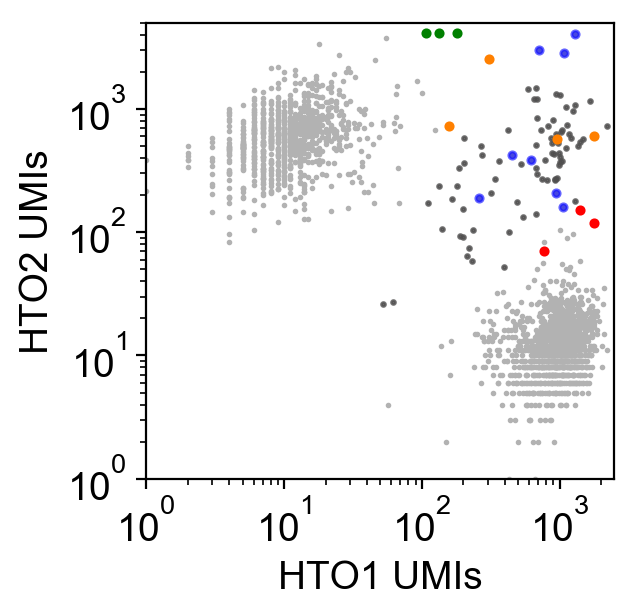

In [3001]:
sam = D_proc['Multi-seq']

x_umap, y_umap = sam.obsm['X_umap'].T

# Plot HTO2 vs. HTO
xdat = 1+sam.obs['Multi1'].values
ydat = 1+sam.obs['Multi2'].values

xdat_sp = sam.obs['hg_count'].values
ydat_sp = sam.obs['mm_count'].values

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(xdat, ydat, alpha=1, s=1, c = '#B2B2B2')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('HTO1 UMIs')
ax.set_ylabel('HTO2 UMIs')


# It turns out the HTO counts are correlated and don't 
# separate as cleanly as we'd like, but we can do 
# better using a sloped line 
m=1
b=0


mask1_er = ma1.T.sum(1) ==2
mask2_er = ma2.T.sum(1) ==2
mask3_er = ma3.T.sum(1) ==2
mask4_er = ma4.T.sum(1) ==2
mask5_er = ma5.T.sum(1) ==2
ax.scatter(xdat[mask5_er], ydat[mask5_er], c='#4F4E4E', s=2, alpha = 0.7, marker = 'o',label = 'True doublets')
ax.scatter(xdat[mask1_er], ydat[mask1_er], c='red', s=7, alpha = 1, marker = 'o', label = 'False positive: hs')
ax.scatter(xdat[mask2_er], ydat[mask2_er], c='green', s=7, alpha = 1, marker = 'o', label = 'False positive: mm')
ax.scatter(xdat[mask3_er], ydat[mask3_er], c='blue', s=7, alpha = 0.6, marker = 'o', label = 'False negative: hs')
ax.scatter(xdat[mask4_er], ydat[mask4_er], c='#ff8000', s=7, alpha = 1, marker = 'o', label = 'False negative: mm')

#
ax.set_xlim(1, 2500)
ax.set_ylim(1, 5000)
#ax.legend()
ax.grid(False)

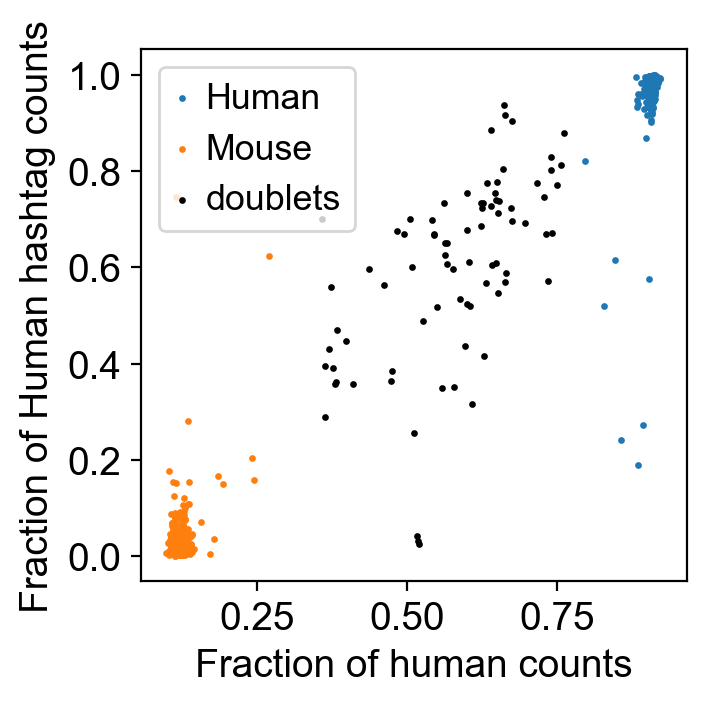

In [2718]:
x = D['Multi-seq'].obs['hg_count']/(D['Multi-seq'].obs['hg_count']+D['Multi-seq'].obs['mm_count'])
y = D['Multi-seq'].obs['Multi1']/(D['Multi-seq'].obs['Multi1']+D['Multi-seq'].obs['Multi2'])

#plt.scatter(x,y, s = 1)
fig, ax = plt.subplots(1, 1, figsize = (3.5, 3.5))
ax.scatter(x[mask1_sp],y[mask1_sp], s = 2, label = 'Human')
ax.scatter(x[mask2_sp],y[mask2_sp], s = 2, label = 'Mouse')
ax.scatter(x[mask3_sp],y[mask3_sp], s = 2, color = 'black', label = 'doublets')
ax.set_xlabel('Fraction of human counts')
ax.set_ylabel('Fraction of Human hashtag counts')
ax.legend()
ax.grid(False)

In [2722]:
import scrublet as scr

In [2728]:
D['Multi-seq']

AnnData object with n_obs × n_vars = 2262 × 82791 
    obs: 'barcode', 'barcode_seq', 'HTO1', 'HTO1_reads', 'HTO7', 'HTO7_reads', 'Multi1', 'Multi1_reads', 'Multi2', 'Multi2_reads', 'Total_human', 'Total_human_reads', 'Total_mouse', 'Total_mouse_reads', 'n_counts_txome', 'n_counts', 'mito_frac', 'hg_count', 'mm_count'
    uns: 'max_mito', 'min_tot'

In [2740]:
scrub = scr.Scrublet(D_proc['Multi-seq'].raw.X, expected_doublet_rate=0.05)
D_proc['Multi-seq'].obs['doublet_score'], D_proc['Multi-seq'].obs['predicted_doublet'] = scrub.scrub_doublets(
    min_cells=3, 
    min_counts=2, 
    min_gene_variability_pctl=0.85,
    n_prin_comps=30
)



Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 48.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.9%
Elapsed time: 5.7 seconds


Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 48.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.9%


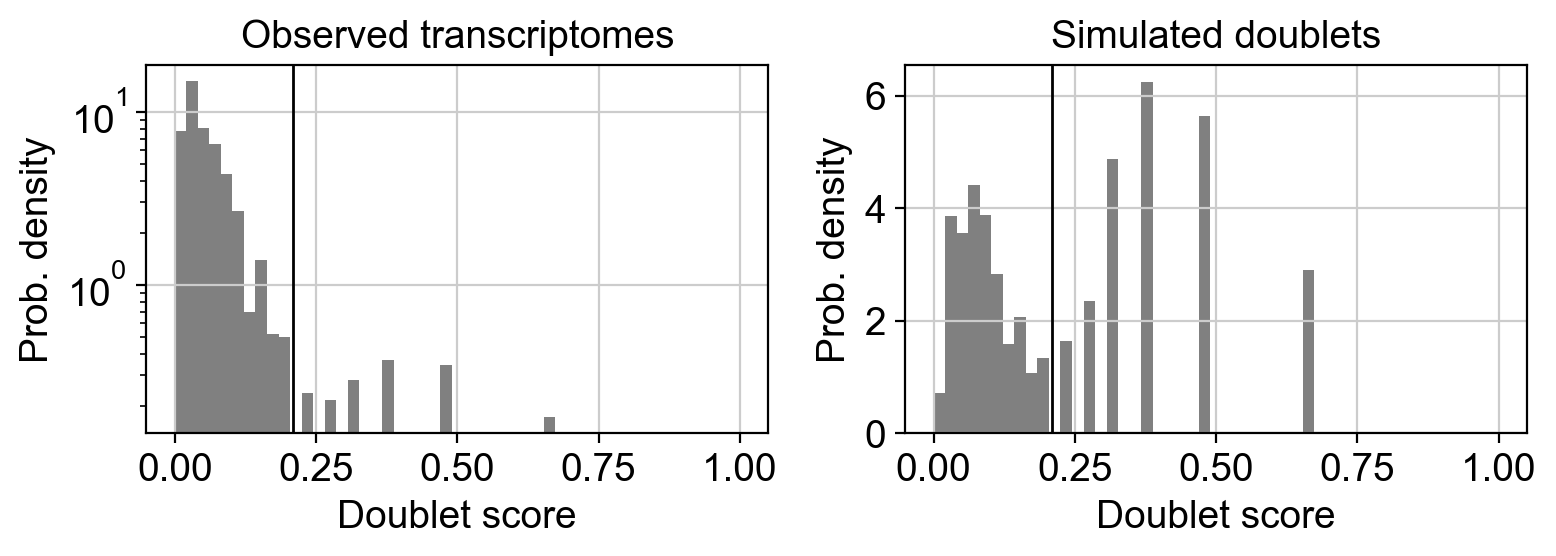

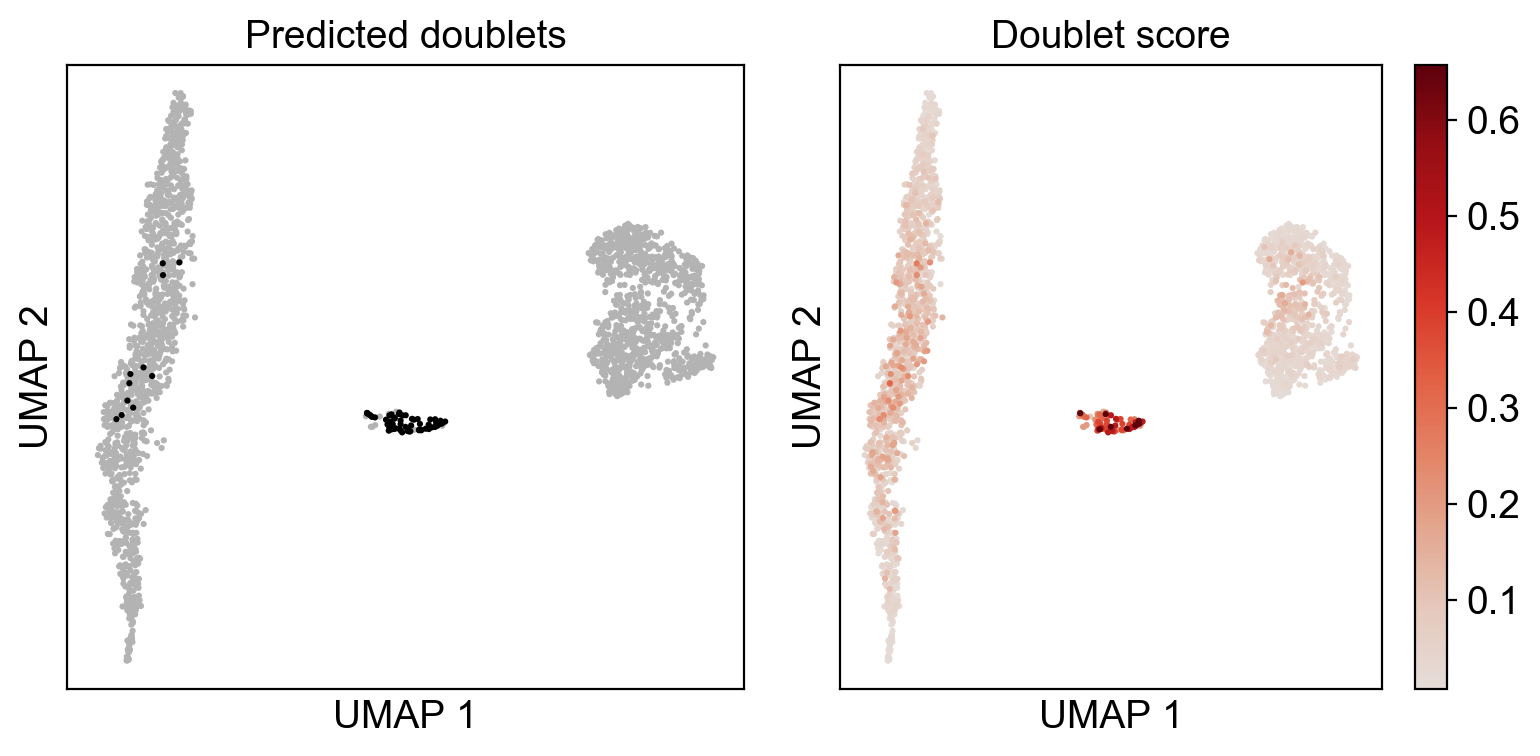

In [2743]:
D_proc['Multi-seq'].obs['predicted_doublet'] = scrub.call_doublets(threshold=0.21)

scrub.plot_histogram();
scrub.set_embedding('UMAP', D_proc['Multi-seq'].obsm['X_umap'])
scrub.plot_embedding('UMAP', order_points=True);